In [1]:
CORE_COUNT = 1

import os

# Limit all relevant threading environments to 1 core
os.environ["OMP_NUM_THREADS"] = str(CORE_COUNT)
os.environ["OPENBLAS_NUM_THREADS"] = str(CORE_COUNT)
os.environ["MKL_NUM_THREADS"] = str(CORE_COUNT)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(CORE_COUNT)
os.environ["NUMEXPR_NUM_THREADS"] = str(CORE_COUNT)
os.environ["STIM_NUM_THREADS"] = str(CORE_COUNT)  # for Stim if it respects this


In [2]:
import sys
sys.path.append("../")
from clapton.clapton import claptonize, claptonize_opt, claptonize_opt_scipy, claptonize_opt_ng, claptonize_opt_tableau_search, claptonize_opt_tableau_search_____, claptonize_opt_tableau_search_vns, claptonize_opt_tableau_search_lns
from clapton.ansatzes import circular_ansatz, full_ansatz
from clapton.utils import Results
import numpy as np
import pickle
import time
import copy


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.problems import ElectronicStructureProblem

from optuna.samplers import TPESampler, RandomSampler, GridSampler, CmaEsSampler, QMCSampler, GPSampler, NSGAIIISampler, NSGAIISampler


import nevergrad as ng
# from nevergrad.families import NonObjectOptimizer
# from nevergrad.optimizers import NGOpt
# from nevergrad.optimization.optimizerlib import EDA, ConfPSO, ParametrizedOnePlusOne, cGA, NoisySplit, MultiDiscrete, AXP, BFGSCMAPlus, CMA, CSEC11, Carola3, ChoiceBase, ForceMultiCobyla, \
#     LogMultiBFGSPlus, MEDA, MetaCMA, MultiBFGSPlus, MultiCobylaPlus, MultiSQPPlus, NGO, PCEDA, SPSA, SQPCMAPlus, Shiwa, SplitOptimizer, Wiz


In [3]:

def generate_h2o_geometry(bond_length: float) -> str:
    """
    Generate H2O geometry with both O–H bonds of equal length,
    forming an angle of ~104.5 degrees.
    """
    angle_deg = 104.5
    angle_rad = np.deg2rad(angle_deg / 2)

    x = bond_length * np.sin(angle_rad)
    z = bond_length * np.cos(angle_rad)

    geometry_str = (
        f"O 0.0 0.0 0.0; "
        f"H {x:.6f} 0.0 {z:.6f}; "
        f"H {-x:.6f} 0.0 {z:.6f}"
    )
    return geometry_str

def generate_linear_h6_geometry(bond_length: float) -> str:
    coords = []
    for i in range(6):
        z = i * bond_length
        coords.append(f"H 0.0 0.0 {z:.6f}")
    return "; ".join(coords)


def generate_ring_h6_geometry(bond_length: float) -> str:
    # Radius r from bond length of regular hexagon
    r = bond_length / (2 * np.sin(np.pi / 6))
    coords = []
    for i in range(6):
        angle = i * np.pi / 3  # 60° steps
        x = r * np.cos(angle)
        y = r * np.sin(angle)
        coords.append(f"H {x:.6f} {y:.6f} 0.0")
    return "; ".join(coords)


In [ ]:
hamiltonian_strings = []
hamiltonian_strings += [f"H 0 0 0; H 0 0 {bond_length :.3f}" for bond_length in np.arange(0.37, 3.0, 0.1)]
hamiltonian_strings += [f"Li 0 0 0; H 0 0 {bond_length :.3f}" for bond_length in np.arange(0.8, 4.8, 0.1)]
hamiltonian_strings += [generate_h2o_geometry(bond_length) for bond_length in np.arange(0.5, 4.0, 0.1)]
# hamiltonian_strings += [generate_ring_h6_geometry(bond_length) for bond_length in np.arange(0.45, 3.6, 0.1)]
print(hamiltonian_strings)


# GA_results = Results(f"GA-{optimizer_name}")
# exact_results = Results(f"exact-{optimizer_name}")
optuna_results = Results(f"lns-search")

for i, hamiltonian_string in enumerate(hamiltonian_strings):
    print(f"=================================")
    print(f"Starting {i+1}/{len(hamiltonian_strings)}: {hamiltonian_string}")
    print(f"=================================")
    driver = PySCFDriver(atom=hamiltonian_string, basis="sto-3g")
    problem = driver.run()
    second_q_op = problem.hamiltonian.second_q_op()

    mapper = ParityMapper()
    qubit_op = mapper.map(second_q_op)

    paulis_ = qubit_op.paulis.to_labels()
    coeffs_ = qubit_op.coeffs
    
    if np.all(np.abs(coeffs_.imag) < 1e-10) is False:
        print(f"Skipping {hamiltonian_string} due to complex coefficients.")
        continue

    # numpy_solver = NumPyMinimumEigensolver()
    # calc = GroundStateEigensolver(mapper, numpy_solver)

    # exact_time = time.time()
    # res = calc.solve(problem)
    # exact_time = time.time() - exact_time
    # exact_results.add_result(hamiltonian_string, paulis_, coeffs_.real.astype(float).tolist(), exact_time, 0, float(res.groundenergy))
    
    
    #############################
    
    coeffs_ = coeffs_.real.astype(float)

    vqe_pcirc_ = circular_ansatz(N=len(paulis_[0]), reps=1, fix_2q=True)

    #############################

    # vqe_pcirc = copy.deepcopy(vqe_pcirc_)
    # paulis = copy.deepcopy(paulis_)
    # coeffs = copy.deepcopy(coeffs_)

    # GA_time = time.time()
    # ks_best, _, energy_best = claptonize(
    #     paulis,
    #     coeffs,
    #     vqe_pcirc,
    #     n_proc=CORE_COUNT,           # total number of processes in parallel
    #     n_starts=4,         # number of random genetic algorithm starts in parallel
    #     n_rounds=1,         # number of budget rounds, if None it will terminate itself
    #     # callback=print,     # callback for internal parameter (#iteration, energies, ks) processing
    #     budget=20           # budget per genetic algorithm instance
    # )
    # GA_time = time.time() - GA_time

    # GA_results.add_result(hamiltonian_string, paulis, coeffs.tolist(), GA_time, ks_best, float(energy_best))

    vqe_pcirc = copy.deepcopy(vqe_pcirc_)
    paulis = copy.deepcopy(paulis_)
    coeffs = copy.deepcopy(coeffs_)

    optuna_time = time.time()
    ks_best, _, energy_best = claptonize_opt_tableau_search_lns(
        paulis,
        coeffs,
        vqe_pcirc,
        # ng_optimizer=sampler_   ,  # "Nelder-Mead", "L-BFGS-B", "COBYLA", "trust-constr"
        # budget=300,
        # n_proc=CORE_COUNT
        max_iters=2,
        destroy_fraction=0.7
    )
    optuna_time = time.time() - optuna_time
    optuna_results.add_result(hamiltonian_string, paulis, coeffs.tolist(), optuna_time, ks_best, float(energy_best))
    
    
    

    # with open("results/exact", "wb") as file:
    #     pickle.dump(exact_results, file)
    # with open(f"results/GA-{CORE_COUNT}-core", "wb") as file:
    #     pickle.dump(GA_results, file)
    with open(f"results/lns-search-{CORE_COUNT}-core", "wb") as file:
        pickle.dump(optuna_results, file)
        

['H 0 0 0; H 0 0 0.370', 'H 0 0 0; H 0 0 0.470', 'H 0 0 0; H 0 0 0.570', 'H 0 0 0; H 0 0 0.670', 'H 0 0 0; H 0 0 0.770', 'H 0 0 0; H 0 0 0.870', 'H 0 0 0; H 0 0 0.970', 'H 0 0 0; H 0 0 1.070', 'H 0 0 0; H 0 0 1.170', 'H 0 0 0; H 0 0 1.270', 'H 0 0 0; H 0 0 1.370', 'H 0 0 0; H 0 0 1.470', 'H 0 0 0; H 0 0 1.570', 'H 0 0 0; H 0 0 1.670', 'H 0 0 0; H 0 0 1.770', 'H 0 0 0; H 0 0 1.870', 'H 0 0 0; H 0 0 1.970', 'H 0 0 0; H 0 0 2.070', 'H 0 0 0; H 0 0 2.170', 'H 0 0 0; H 0 0 2.270', 'H 0 0 0; H 0 0 2.370', 'H 0 0 0; H 0 0 2.470', 'H 0 0 0; H 0 0 2.570', 'H 0 0 0; H 0 0 2.670', 'H 0 0 0; H 0 0 2.770', 'H 0 0 0; H 0 0 2.870', 'H 0 0 0; H 0 0 2.970', 'Li 0 0 0; H 0 0 0.800', 'Li 0 0 0; H 0 0 0.900', 'Li 0 0 0; H 0 0 1.000', 'Li 0 0 0; H 0 0 1.100', 'Li 0 0 0; H 0 0 1.200', 'Li 0 0 0; H 0 0 1.300', 'Li 0 0 0; H 0 0 1.400', 'Li 0 0 0; H 0 0 1.500', 'Li 0 0 0; H 0 0 1.600', 'Li 0 0 0; H 0 0 1.700', 'Li 0 0 0; H 0 0 1.800', 'Li 0 0 0; H 0 0 1.900', 'Li 0 0 0; H 0 0 2.000', 'Li 0 0 0; H 0 0 2.100', '

# Plotting

In [5]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science"])

In [6]:
def drop_laters(results: Results, count):
    """
    Drop later results in the list.
    """
    res = copy.deepcopy(results)
    res.bond_lengths = results.bond_lengths[:count]
    res.energy_bests = results.energy_bests[:count]
    res.times = results.times[:count]
    return res

def drop_ends(results: Results, prefix, suffix):
    """
    Drop later results in the list.
    """
    res = copy.deepcopy(results)
    res.bond_lengths = results.bond_lengths[prefix+1:suffix]
    res.energy_bests = results.energy_bests[prefix+1:suffix]
    res.times = results.times[prefix+1:suffix]
    return res

In [11]:

results_list = []

with open("results/GA-16-core", "rb") as file:
    GA_results = pickle.load(file)
# GA_results = drop_laters(GA_results, 102)
GA_results = drop_ends(GA_results, 0, 102)
results_list += [GA_results]

with open("results/exact", "rb") as file:
    exact_results = pickle.load(file)
# exact_results = drop_laters(exact_results, 102)
exact_results = drop_ends(exact_results, 0, 102)
results_list += [exact_results]

with open(f"results/lns-search-1-core", "rb") as file:
    optuna_results = pickle.load(file)
# optuna_results = drop_laters(optuna_results, 102)
optuna_results = drop_ends(optuna_results, 0, 102)
results_list += [optuna_results]


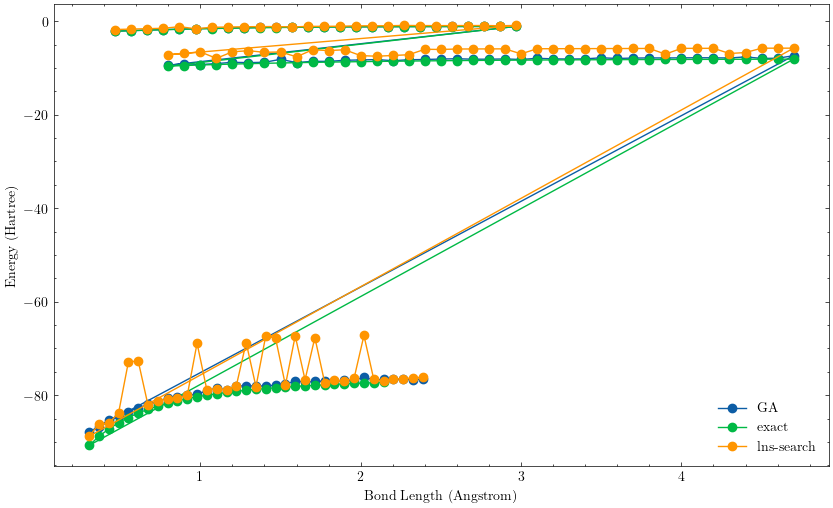

<Figure size 350x262.5 with 0 Axes>

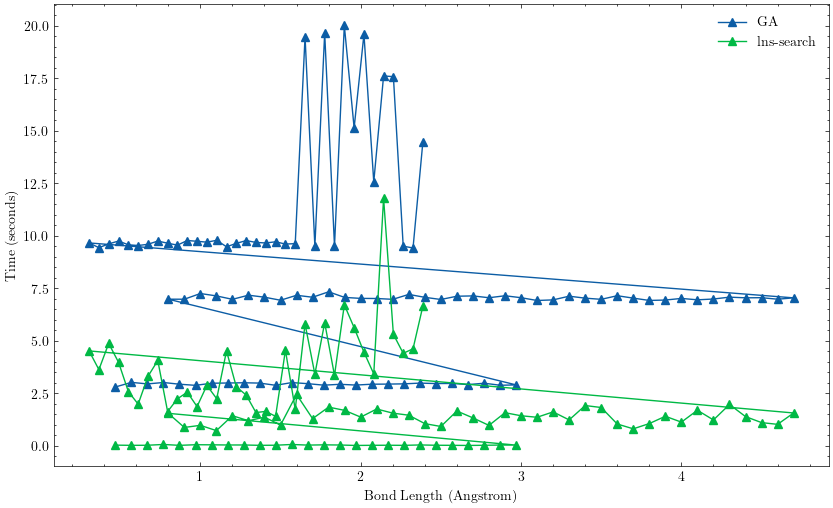

<Figure size 350x262.5 with 0 Axes>

In [12]:
plt.figure(figsize=(10, 6))
for results in results_list:
    plt.plot(results.bond_lengths, results.energy_bests, label=results.name, marker="o")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.show()
plt.clf()

# plt.figure(figsize=(10, 6))
# for results in results_list:
#     if results.name == "exact":
#         continue
#     plt.plot(results.bond_lengths, np.array(results.energy_bests) - np.array(exact_results.energy_bests), label=results.name, marker="o")
# # plt.ylim(0, 0.1)
# plt.xlabel("Bond Length (Angstrom)")
# plt.ylabel("Energy Error (Hartree)")
# plt.legend()
# plt.show()
# plt.clf()

plt.figure(figsize=(10, 6))
for results in results_list:
    if results.name == "exact":
        continue
    plt.plot(results.bond_lengths, results.times, label=results.name, marker="^")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()
plt.clf()





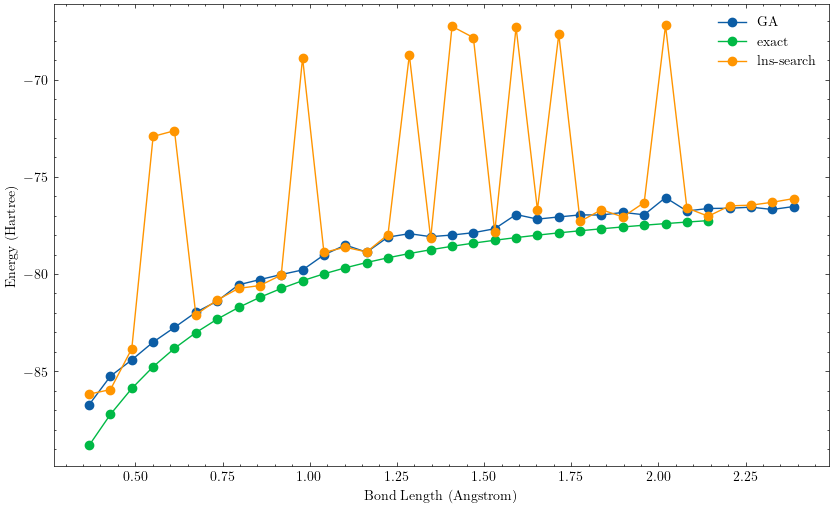

<Figure size 350x262.5 with 0 Axes>

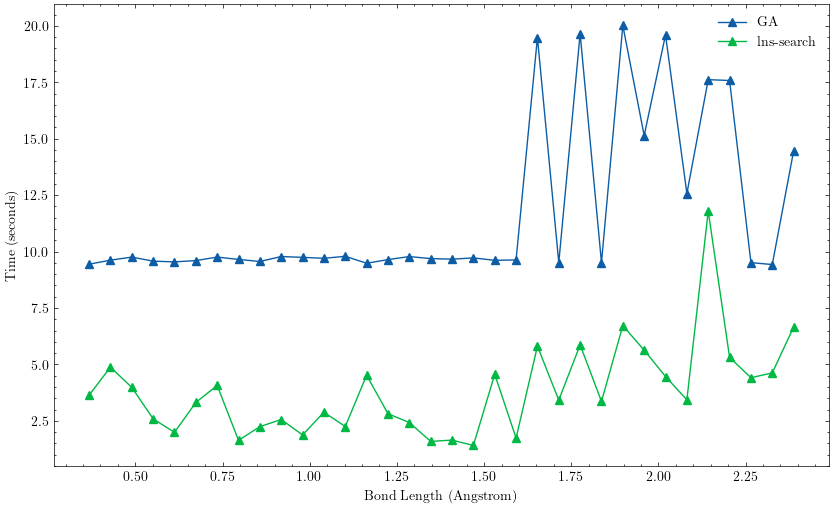

<Figure size 350x262.5 with 0 Axes>

In [9]:
plt.figure(figsize=(10, 6))
for results in results_list:
    plt.plot(results.bond_lengths, results.energy_bests, label=results.name, marker="o")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.show()
plt.clf()

# plt.figure(figsize=(10, 6))
# for results in results_list:
#     if results.name == "exact":
#         continue
#     plt.plot(results.bond_lengths, np.array(results.energy_bests) - np.array(exact_results.energy_bests), label=results.name, marker="o")
# # plt.ylim(0, 0.1)
# plt.xlabel("Bond Length (Angstrom)")
# plt.ylabel("Energy Error (Hartree)")
# plt.legend()
# plt.show()
# plt.clf()

plt.figure(figsize=(10, 6))
for results in results_list:
    if results.name == "exact":
        continue
    plt.plot(results.bond_lengths, results.times, label=results.name, marker="^")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()
plt.clf()





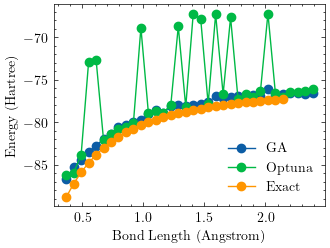

ValueError: operands could not be broadcast together with shapes (34,) (30,) 

<Figure size 350x262.5 with 0 Axes>

In [10]:
plt.plot(GA_results.bond_lengths, GA_results.energy_bests, label="GA", marker="o")
plt.plot(optuna_results.bond_lengths, optuna_results.energy_bests, label="Optuna", marker="o")
plt.plot(exact_results.bond_lengths, exact_results.energy_bests, label="Exact", marker="o")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.show()
plt.clf()

plt.plot(GA_results.bond_lengths, np.array(GA_results.energy_bests) - np.array(exact_results.energy_bests), label="GA", marker="o")
plt.plot(optuna_results.bond_lengths, np.array(optuna_results.energy_bests) - np.array(exact_results.energy_bests), label="Optuna", marker="o")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy Error (Hartree)")
plt.legend()
plt.show()
plt.clf()


plt.plot(GA_results.bond_lengths, GA_results.times, label="GA", marker="^")
plt.plot(optuna_results.bond_lengths, optuna_results.times, label="Optuna", marker="^")
# plt.plot(exact_results.bond_lengths, exact_results.times, label="Exact", marker="^")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()
plt.clf()



